In [1]:
!pip install segmentation_models_pytorch warmup_scheduler albumentations -q


In [2]:
import os
import sys
import random
from glob import glob
import warnings

import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2

sys.path.append('/kaggle/working/notebook/experiment/2d')
from script.helper import *
from script.dataset import *
from script.metrics import *
from script.trainer import *
from script.model import *
from script.loss import *
from script.scheduler import *


## config

In [3]:
class ExtractLayers(A.ImageOnlyTransform):
    def __init__(self, in_channels, out_channels, is_train=True, always_apply=False, p=1):
        super(ExtractLayers, self).__init__(always_apply, p)
        self.is_train = is_train
        self.in_channels = in_channels
        self.out_channels = out_channels

    def apply(self, img, **params):
        if self.is_train:
            start = random.randint(0, self.in_channels-self.out_channels)
            end = start+self.out_channels
            img = img[:, :, start:end]
        else:
            img = img[:, :, 4:4+self.out_channels]
        return img


In [4]:
class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'
    comp_dir_path = '/kaggle/input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'

    dataset_path = "/kaggle/working/dataset_train/"
    train_dataset_path = "/kaggle/working/dataset_train/nonflatten/25-37/"
    dataset_range = train_dataset_path.split("/")[-2]
    
    exp_name = os.getcwd().split('/')[-1]

    # ============== model cfg =============
    model_name = 'UnetPlusPlus'
    backbone = 'se_resnext101_32x4d'
    in_chans = 6

    # ============== pred target =============
    target_size = 1

    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16  # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'

    epochs = 20  # 15

    warmup_factor = 10
    lr = 1e-4 / warmup_factor
    loss="bce_dice_loss"
    # ============== fold =============
    metric_direction = 'maximize'  # maximize, 'minimize'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== augmentation =============
    train_aug_list = [
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.ShiftScaleRotate(p=0.5),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3),
                        mask_fill_value=0, p=0.5),
        ExtractLayers(13, 6, is_train=True),
        A.Normalize(
            mean=[0] * in_chans,
            std=[1] * in_chans,
            max_pixel_value=65535,
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        ExtractLayers(13, 6, is_train=False),
        A.Normalize(
            mean=[0] * in_chans,
            std=[1] * in_chans,
            max_pixel_value=65535,
        ),
        ToTensorV2(transpose_mask=True),
    ]


warnings.filterwarnings("ignore")
torch.backends.cudnn.benchmark = True  # type: ignore

set_seed(CFG.seed)
os.makedirs(f'./{CFG.exp_name}/', exist_ok=True)


## Dataset

In [5]:
def preprocess(image, fragment_i, split_i):
    # topography = cv2.imread(f"{CFG.dataset_path}/topography_{fragment_i}_{split_i}.png",-1)
    # topography = topography.astype("uint16")*1057
    # pad0 = (CFG.tile_size - topography.shape[0] % CFG.tile_size)
    # pad1 = (CFG.tile_size - topography.shape[1] % CFG.tile_size)
    # topography = np.pad(topography, [(0, pad0), (0, pad1)], constant_values=0)
    # topography = np.expand_dims(topography, axis=2)
    # image=np.concatenate([image,topography], axis=2)
    return image



len(train_images) = 14624
train_images[0].shape = (224, 224, 13)
train_labels[0].shape = (224, 224, 1)
train_masks[0].shape = (224, 224, 1)

len(valid_images) = 4161
valid_images[0].shape = (224, 224, 13)
valid_labels[0].shape = (224, 224, 1)



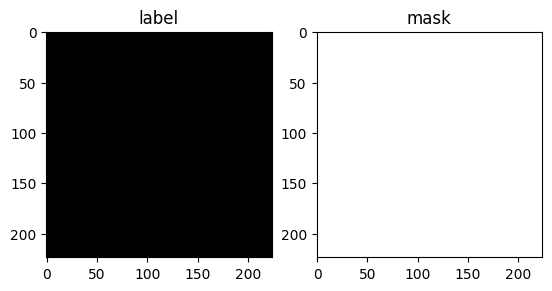

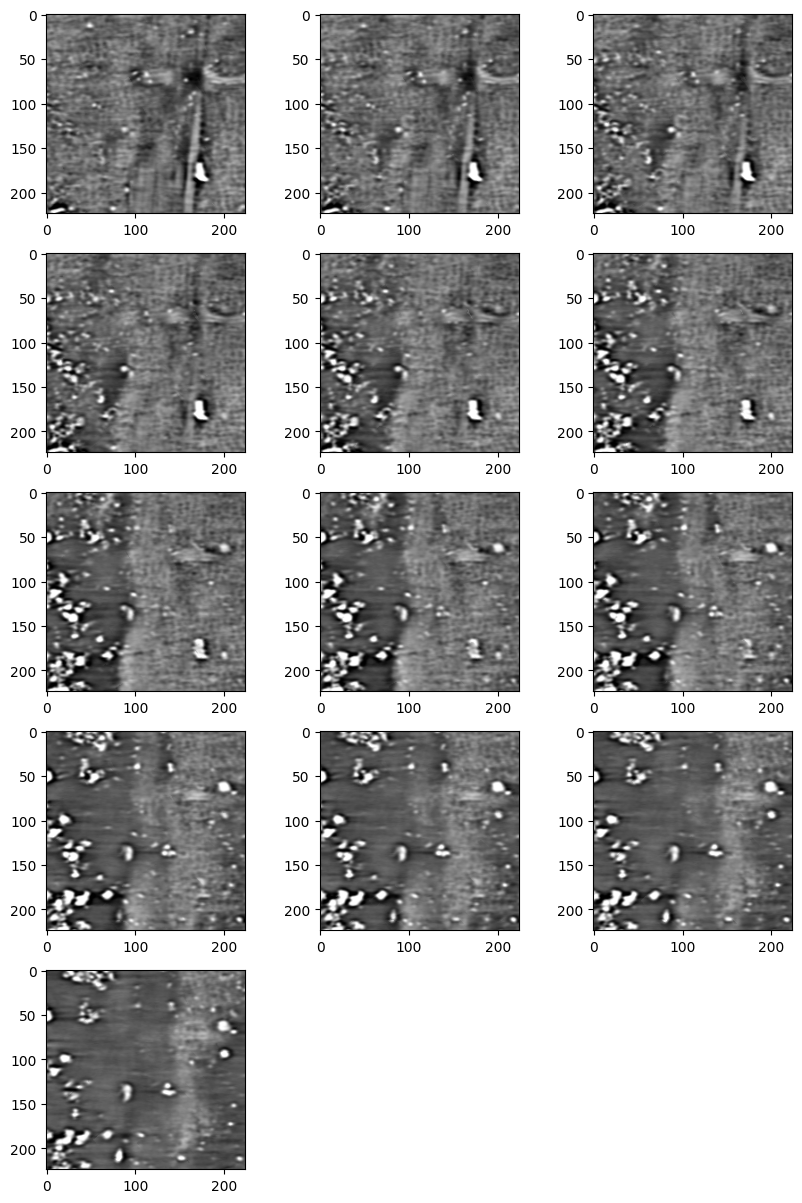

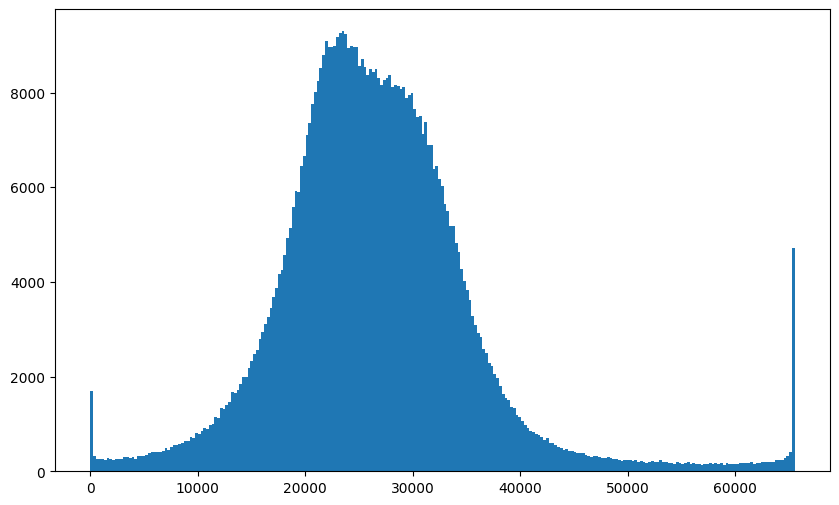

In [6]:
# confirmation

valid_fragment_i = 1
valid_split_i = 0

train_images, train_labels, train_masks, valid_images, valid_labels, valid_xyxys = get_train_valid_dataset(valid_fragment_i, valid_split_i, CFG, preprocess)

print(f"""
{len(train_images) = }
{train_images[0].shape = }
{train_labels[0].shape = }
{train_masks[0].shape = }

{len(valid_images) = }
{valid_images[0].shape = }
{valid_labels[0].shape = }
""")

id = random.randint(0, len(train_labels))
visualize_train_images(id, train_images, train_labels, train_masks)


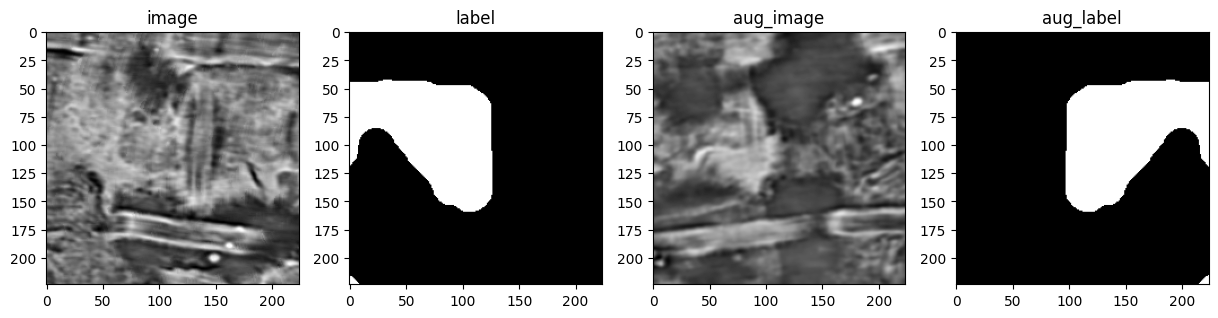

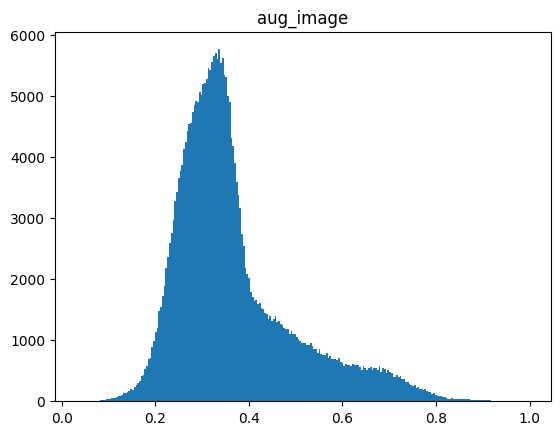

In [7]:
# confirmation
plot_dataset = CustomDataset(train_images, CFG, labels=train_labels)
visualize_dataset(plot_dataset, CFG)


## main

In [8]:
train_and_evaluate(preprocess, CFG)
!curl -X POST -H 'Authorization: Bearer '$LINE -F 'message=セルの実行が終わりました！' https://notify-api.line.me/api/notify

fold: 0
UnetPlusPlus


100%|██████████| 131/131 [00:15<00:00,  8.68it/s]


fbeta: 0.3727
Epoch 1 - avg_train_loss: 1.1881  avg_val_loss: 1.0021  avgScore: 0.3727  time: 196s
Epoch 1 - Save Best Loss: 1.0021  Best Score: 0.3727 Model



100%|██████████| 131/131 [00:14<00:00,  8.76it/s]


fbeta: 0.3509
Epoch 2 - avg_train_loss: 1.0675  avg_val_loss: 1.0234  avgScore: 0.3509  time: 195s



100%|██████████| 131/131 [00:15<00:00,  8.73it/s]


fbeta: 0.4267
Epoch 3 - avg_train_loss: 0.9936  avg_val_loss: 0.8817  avgScore: 0.4267  time: 194s
Epoch 3 - Save Best Loss: 0.8817  Best Score: 0.4267 Model



100%|██████████| 131/131 [00:14<00:00,  8.98it/s]


fbeta: 0.4187
Epoch 4 - avg_train_loss: 0.8866  avg_val_loss: 0.9148  avgScore: 0.4187  time: 191s



100%|██████████| 131/131 [00:14<00:00,  9.00it/s]


fbeta: 0.4429
Epoch 5 - avg_train_loss: 0.8479  avg_val_loss: 0.8785  avgScore: 0.4429  time: 190s
Epoch 5 - Save Best Loss: 0.8785  Best Score: 0.4429 Model



100%|██████████| 131/131 [00:14<00:00,  9.02it/s]


fbeta: 0.4150
Epoch 6 - avg_train_loss: 0.8493  avg_val_loss: 0.9219  avgScore: 0.4150  time: 190s



100%|██████████| 131/131 [00:14<00:00,  9.01it/s]


fbeta: 0.4365
Epoch 7 - avg_train_loss: 0.8082  avg_val_loss: 0.9155  avgScore: 0.4365  time: 190s



100%|██████████| 131/131 [00:14<00:00,  9.02it/s]


fbeta: 0.4321
Epoch 8 - avg_train_loss: 0.7806  avg_val_loss: 0.8851  avgScore: 0.4321  time: 191s



100%|██████████| 131/131 [00:14<00:00,  9.00it/s]


fbeta: 0.5004
Epoch 9 - avg_train_loss: 0.7437  avg_val_loss: 0.8414  avgScore: 0.5004  time: 190s
Epoch 9 - Save Best Loss: 0.8414  Best Score: 0.5004 Model



100%|██████████| 131/131 [00:14<00:00,  8.97it/s]


fbeta: 0.4344
Epoch 10 - avg_train_loss: 0.7216  avg_val_loss: 0.9057  avgScore: 0.4344  time: 190s



100%|██████████| 131/131 [00:14<00:00,  8.99it/s]


fbeta: 0.4823
Epoch 11 - avg_train_loss: 0.6890  avg_val_loss: 0.8906  avgScore: 0.4823  time: 191s



100%|██████████| 131/131 [00:14<00:00,  9.01it/s]


fbeta: 0.5076
Epoch 12 - avg_train_loss: 0.6713  avg_val_loss: 0.8455  avgScore: 0.5076  time: 190s
Epoch 12 - Save Best Loss: 0.8455  Best Score: 0.5076 Model



100%|██████████| 131/131 [00:14<00:00,  8.81it/s]


fbeta: 0.5030
Epoch 13 - avg_train_loss: 0.6686  avg_val_loss: 0.9208  avgScore: 0.5030  time: 192s



100%|██████████| 131/131 [00:14<00:00,  8.74it/s]


fbeta: 0.5060
Epoch 14 - avg_train_loss: 0.6547  avg_val_loss: 0.9535  avgScore: 0.5060  time: 194s



100%|██████████| 131/131 [00:14<00:00,  8.73it/s]


fbeta: 0.4941
Epoch 15 - avg_train_loss: 0.6297  avg_val_loss: 0.8851  avgScore: 0.4941  time: 194s



100%|██████████| 131/131 [00:14<00:00,  8.80it/s]


fbeta: 0.5364
Epoch 16 - avg_train_loss: 0.6154  avg_val_loss: 0.8911  avgScore: 0.5364  time: 194s
Epoch 16 - Save Best Loss: 0.8911  Best Score: 0.5364 Model



100%|██████████| 131/131 [00:14<00:00,  9.01it/s]


fbeta: 0.5038
Epoch 17 - avg_train_loss: 0.5846  avg_val_loss: 0.8838  avgScore: 0.5038  time: 192s



100%|██████████| 131/131 [00:14<00:00,  9.01it/s]


fbeta: 0.5300
Epoch 18 - avg_train_loss: 0.5792  avg_val_loss: 0.9172  avgScore: 0.5300  time: 189s



100%|██████████| 131/131 [00:14<00:00,  9.01it/s]


fbeta: 0.5203
Epoch 19 - avg_train_loss: 0.5656  avg_val_loss: 0.8949  avgScore: 0.5203  time: 190s



100%|██████████| 131/131 [00:14<00:00,  8.99it/s]


fbeta: 0.5164
Epoch 20 - avg_train_loss: 0.5578  avg_val_loss: 0.8852  avgScore: 0.5164  time: 190s

fold: 1
UnetPlusPlus


100%|██████████| 120/120 [00:13<00:00,  8.89it/s]


fbeta: 0.3725
Epoch 1 - avg_train_loss: 1.3129  avg_val_loss: 0.8376  avgScore: 0.3725  time: 195s
Epoch 1 - Save Best Loss: 0.8376  Best Score: 0.3725 Model



100%|██████████| 120/120 [00:13<00:00,  8.87it/s]


fbeta: 0.4414
Epoch 2 - avg_train_loss: 1.1437  avg_val_loss: 0.7812  avgScore: 0.4414  time: 194s
Epoch 2 - Save Best Loss: 0.7812  Best Score: 0.4414 Model



100%|██████████| 120/120 [00:13<00:00,  8.91it/s]


fbeta: 0.3871
Epoch 3 - avg_train_loss: 1.0146  avg_val_loss: 0.6696  avgScore: 0.3871  time: 194s



100%|██████████| 120/120 [00:13<00:00,  8.89it/s]


fbeta: 0.4589
Epoch 4 - avg_train_loss: 0.9203  avg_val_loss: 0.6632  avgScore: 0.4589  time: 194s
Epoch 4 - Save Best Loss: 0.6632  Best Score: 0.4589 Model



100%|██████████| 120/120 [00:13<00:00,  8.88it/s]


fbeta: 0.4670
Epoch 5 - avg_train_loss: 0.8744  avg_val_loss: 0.6020  avgScore: 0.4670  time: 194s
Epoch 5 - Save Best Loss: 0.6020  Best Score: 0.4670 Model



100%|██████████| 120/120 [00:13<00:00,  8.89it/s]


fbeta: 0.5450
Epoch 6 - avg_train_loss: 0.8258  avg_val_loss: 0.6366  avgScore: 0.5450  time: 194s
Epoch 6 - Save Best Loss: 0.6366  Best Score: 0.5450 Model



100%|██████████| 120/120 [00:13<00:00,  8.90it/s]


fbeta: 0.5513
Epoch 7 - avg_train_loss: 0.8227  avg_val_loss: 0.6020  avgScore: 0.5513  time: 193s
Epoch 7 - Save Best Loss: 0.6020  Best Score: 0.5513 Model



100%|██████████| 120/120 [00:13<00:00,  8.86it/s]


fbeta: 0.6043
Epoch 8 - avg_train_loss: 0.7975  avg_val_loss: 0.5762  avgScore: 0.6043  time: 194s
Epoch 8 - Save Best Loss: 0.5762  Best Score: 0.6043 Model



100%|██████████| 120/120 [00:13<00:00,  8.64it/s]


fbeta: 0.5733
Epoch 9 - avg_train_loss: 0.7444  avg_val_loss: 0.5860  avgScore: 0.5733  time: 196s



100%|██████████| 120/120 [00:13<00:00,  8.71it/s]


fbeta: 0.5888
Epoch 10 - avg_train_loss: 0.7208  avg_val_loss: 0.5654  avgScore: 0.5888  time: 198s



100%|██████████| 120/120 [00:13<00:00,  8.60it/s]


fbeta: 0.5803
Epoch 11 - avg_train_loss: 0.7191  avg_val_loss: 0.5682  avgScore: 0.5803  time: 198s



100%|██████████| 120/120 [00:13<00:00,  8.85it/s]


fbeta: 0.5832
Epoch 12 - avg_train_loss: 0.6817  avg_val_loss: 0.5753  avgScore: 0.5832  time: 196s



100%|██████████| 120/120 [00:13<00:00,  8.89it/s]


fbeta: 0.5861
Epoch 13 - avg_train_loss: 0.6782  avg_val_loss: 0.5715  avgScore: 0.5861  time: 193s



100%|██████████| 120/120 [00:13<00:00,  8.87it/s]


fbeta: 0.5694
Epoch 14 - avg_train_loss: 0.6534  avg_val_loss: 0.5812  avgScore: 0.5694  time: 193s



100%|██████████| 120/120 [00:13<00:00,  8.92it/s]


fbeta: 0.5785
Epoch 15 - avg_train_loss: 0.6336  avg_val_loss: 0.5847  avgScore: 0.5785  time: 193s



100%|██████████| 120/120 [00:13<00:00,  8.87it/s]


fbeta: 0.5811
Epoch 16 - avg_train_loss: 0.6042  avg_val_loss: 0.5819  avgScore: 0.5811  time: 194s



100%|██████████| 120/120 [00:13<00:00,  8.88it/s]


fbeta: 0.5498
Epoch 17 - avg_train_loss: 0.5899  avg_val_loss: 0.5859  avgScore: 0.5498  time: 194s



100%|██████████| 120/120 [00:13<00:00,  8.88it/s]


fbeta: 0.5975
Epoch 18 - avg_train_loss: 0.5801  avg_val_loss: 0.5982  avgScore: 0.5975  time: 193s



100%|██████████| 120/120 [00:13<00:00,  8.89it/s]


fbeta: 0.5881
Epoch 19 - avg_train_loss: 0.5672  avg_val_loss: 0.5922  avgScore: 0.5881  time: 194s



100%|██████████| 120/120 [00:13<00:00,  8.91it/s]


fbeta: 0.6062
Epoch 20 - avg_train_loss: 0.5601  avg_val_loss: 0.5858  avgScore: 0.6062  time: 193s
Epoch 20 - Save Best Loss: 0.5858  Best Score: 0.6062 Model

fold: 2
UnetPlusPlus


100%|██████████| 120/120 [00:13<00:00,  8.82it/s]


fbeta: 0.3530
Epoch 1 - avg_train_loss: 1.1933  avg_val_loss: 1.2192  avgScore: 0.3530  time: 194s
Epoch 1 - Save Best Loss: 1.2192  Best Score: 0.3530 Model



100%|██████████| 120/120 [00:13<00:00,  8.82it/s]


fbeta: 0.3957
Epoch 2 - avg_train_loss: 1.0669  avg_val_loss: 1.1396  avgScore: 0.3957  time: 194s
Epoch 2 - Save Best Loss: 1.1396  Best Score: 0.3957 Model



100%|██████████| 120/120 [00:13<00:00,  8.83it/s]


fbeta: 0.4551
Epoch 3 - avg_train_loss: 0.9783  avg_val_loss: 1.0635  avgScore: 0.4551  time: 194s
Epoch 3 - Save Best Loss: 1.0635  Best Score: 0.4551 Model



100%|██████████| 120/120 [00:13<00:00,  8.76it/s]


fbeta: 0.4931
Epoch 4 - avg_train_loss: 0.8704  avg_val_loss: 1.0512  avgScore: 0.4931  time: 195s
Epoch 4 - Save Best Loss: 1.0512  Best Score: 0.4931 Model



100%|██████████| 120/120 [00:13<00:00,  8.64it/s]


fbeta: 0.5108
Epoch 5 - avg_train_loss: 0.8423  avg_val_loss: 1.1076  avgScore: 0.5108  time: 196s
Epoch 5 - Save Best Loss: 1.1076  Best Score: 0.5108 Model



100%|██████████| 120/120 [00:13<00:00,  8.60it/s]


fbeta: 0.4820
Epoch 6 - avg_train_loss: 0.8227  avg_val_loss: 1.0588  avgScore: 0.4820  time: 199s



100%|██████████| 120/120 [00:13<00:00,  8.61it/s]


fbeta: 0.5168
Epoch 7 - avg_train_loss: 0.7926  avg_val_loss: 1.1617  avgScore: 0.5168  time: 197s
Epoch 7 - Save Best Loss: 1.1617  Best Score: 0.5168 Model



100%|██████████| 120/120 [00:13<00:00,  8.62it/s]


fbeta: 0.5461
Epoch 8 - avg_train_loss: 0.7678  avg_val_loss: 1.0580  avgScore: 0.5461  time: 199s
Epoch 8 - Save Best Loss: 1.0580  Best Score: 0.5461 Model



100%|██████████| 120/120 [00:13<00:00,  8.83it/s]


fbeta: 0.4940
Epoch 9 - avg_train_loss: 0.7445  avg_val_loss: 1.0701  avgScore: 0.4940  time: 194s



100%|██████████| 120/120 [00:13<00:00,  8.82it/s]


fbeta: 0.5260
Epoch 10 - avg_train_loss: 0.7278  avg_val_loss: 1.0154  avgScore: 0.5260  time: 195s



100%|██████████| 120/120 [00:13<00:00,  8.82it/s]


fbeta: 0.5759
Epoch 11 - avg_train_loss: 0.7018  avg_val_loss: 1.0212  avgScore: 0.5759  time: 194s
Epoch 11 - Save Best Loss: 1.0212  Best Score: 0.5759 Model



100%|██████████| 120/120 [00:13<00:00,  8.78it/s]


fbeta: 0.5846
Epoch 12 - avg_train_loss: 0.6683  avg_val_loss: 1.0744  avgScore: 0.5846  time: 195s
Epoch 12 - Save Best Loss: 1.0744  Best Score: 0.5846 Model



100%|██████████| 120/120 [00:13<00:00,  8.86it/s]


fbeta: 0.5706
Epoch 13 - avg_train_loss: 0.6493  avg_val_loss: 1.0890  avgScore: 0.5706  time: 193s



100%|██████████| 120/120 [00:13<00:00,  8.60it/s]


fbeta: 0.5724
Epoch 14 - avg_train_loss: 0.6408  avg_val_loss: 1.0619  avgScore: 0.5724  time: 198s



100%|██████████| 120/120 [00:13<00:00,  8.61it/s]


fbeta: 0.5679
Epoch 15 - avg_train_loss: 0.6183  avg_val_loss: 1.0989  avgScore: 0.5679  time: 198s



100%|██████████| 120/120 [00:13<00:00,  8.59it/s]


fbeta: 0.5561
Epoch 16 - avg_train_loss: 0.5896  avg_val_loss: 1.0530  avgScore: 0.5561  time: 197s



100%|██████████| 120/120 [00:13<00:00,  8.84it/s]


fbeta: 0.5699
Epoch 17 - avg_train_loss: 0.5767  avg_val_loss: 1.0495  avgScore: 0.5699  time: 194s



100%|██████████| 120/120 [00:13<00:00,  8.82it/s]


fbeta: 0.5984
Epoch 18 - avg_train_loss: 0.5697  avg_val_loss: 1.1269  avgScore: 0.5984  time: 194s
Epoch 18 - Save Best Loss: 1.1269  Best Score: 0.5984 Model



100%|██████████| 120/120 [00:13<00:00,  8.82it/s]


fbeta: 0.5879
Epoch 19 - avg_train_loss: 0.5614  avg_val_loss: 1.0814  avgScore: 0.5879  time: 195s



100%|██████████| 120/120 [00:13<00:00,  8.84it/s]


fbeta: 0.5876
Epoch 20 - avg_train_loss: 0.5636  avg_val_loss: 1.0823  avgScore: 0.5876  time: 193s

fold: 3
UnetPlusPlus


100%|██████████| 120/120 [00:13<00:00,  8.76it/s]


fbeta: 0.4027
Epoch 1 - avg_train_loss: 1.2891  avg_val_loss: 1.0734  avgScore: 0.4027  time: 194s
Epoch 1 - Save Best Loss: 1.0734  Best Score: 0.4027 Model



100%|██████████| 120/120 [00:13<00:00,  8.71it/s]


fbeta: 0.4776
Epoch 2 - avg_train_loss: 1.0901  avg_val_loss: 0.9978  avgScore: 0.4776  time: 194s
Epoch 2 - Save Best Loss: 0.9978  Best Score: 0.4776 Model



100%|██████████| 120/120 [00:13<00:00,  8.76it/s]


fbeta: 0.4265
Epoch 3 - avg_train_loss: 0.9791  avg_val_loss: 1.0050  avgScore: 0.4265  time: 194s



100%|██████████| 120/120 [00:13<00:00,  8.80it/s]


fbeta: 0.5294
Epoch 4 - avg_train_loss: 0.9124  avg_val_loss: 0.9249  avgScore: 0.5294  time: 194s
Epoch 4 - Save Best Loss: 0.9249  Best Score: 0.5294 Model



100%|██████████| 120/120 [00:13<00:00,  8.75it/s]


fbeta: 0.5375
Epoch 5 - avg_train_loss: 0.8448  avg_val_loss: 0.9555  avgScore: 0.5375  time: 194s
Epoch 5 - Save Best Loss: 0.9555  Best Score: 0.5375 Model



100%|██████████| 120/120 [00:13<00:00,  8.58it/s]


fbeta: 0.6001
Epoch 6 - avg_train_loss: 0.8187  avg_val_loss: 0.8752  avgScore: 0.6001  time: 198s
Epoch 6 - Save Best Loss: 0.8752  Best Score: 0.6001 Model



100%|██████████| 120/120 [00:14<00:00,  8.53it/s]


fbeta: 0.5833
Epoch 7 - avg_train_loss: 0.8154  avg_val_loss: 0.8809  avgScore: 0.5833  time: 198s



100%|██████████| 120/120 [00:13<00:00,  8.59it/s]


fbeta: 0.4422
Epoch 8 - avg_train_loss: 0.7701  avg_val_loss: 1.0626  avgScore: 0.4422  time: 198s



100%|██████████| 120/120 [00:13<00:00,  8.68it/s]


fbeta: 0.5068
Epoch 9 - avg_train_loss: 0.7529  avg_val_loss: 1.0237  avgScore: 0.5068  time: 199s



100%|██████████| 120/120 [00:13<00:00,  8.67it/s]


fbeta: 0.6020
Epoch 10 - avg_train_loss: 0.7297  avg_val_loss: 0.8787  avgScore: 0.6020  time: 197s
Epoch 10 - Save Best Loss: 0.8787  Best Score: 0.6020 Model



100%|██████████| 120/120 [00:13<00:00,  8.67it/s]


fbeta: 0.6343
Epoch 11 - avg_train_loss: 0.7271  avg_val_loss: 0.8517  avgScore: 0.6343  time: 195s
Epoch 11 - Save Best Loss: 0.8517  Best Score: 0.6343 Model



100%|██████████| 120/120 [00:13<00:00,  8.67it/s]


fbeta: 0.5250
Epoch 12 - avg_train_loss: 0.6958  avg_val_loss: 0.9561  avgScore: 0.5250  time: 196s



100%|██████████| 120/120 [00:13<00:00,  8.79it/s]


fbeta: 0.5557
Epoch 13 - avg_train_loss: 0.6782  avg_val_loss: 0.9032  avgScore: 0.5557  time: 194s



100%|██████████| 120/120 [00:13<00:00,  8.78it/s]


fbeta: 0.6192
Epoch 14 - avg_train_loss: 0.6506  avg_val_loss: 0.9035  avgScore: 0.6192  time: 194s



100%|██████████| 120/120 [00:14<00:00,  8.40it/s]


fbeta: 0.6253
Epoch 15 - avg_train_loss: 0.6357  avg_val_loss: 0.8608  avgScore: 0.6253  time: 198s



100%|██████████| 120/120 [00:13<00:00,  8.61it/s]


fbeta: 0.6346
Epoch 16 - avg_train_loss: 0.6307  avg_val_loss: 0.8563  avgScore: 0.6346  time: 196s
Epoch 16 - Save Best Loss: 0.8563  Best Score: 0.6346 Model



100%|██████████| 120/120 [00:14<00:00,  8.53it/s]


fbeta: 0.6315
Epoch 17 - avg_train_loss: 0.5933  avg_val_loss: 0.8804  avgScore: 0.6315  time: 196s



100%|██████████| 120/120 [00:14<00:00,  8.56it/s]


fbeta: 0.6322
Epoch 18 - avg_train_loss: 0.5938  avg_val_loss: 0.8595  avgScore: 0.6322  time: 199s



100%|██████████| 120/120 [00:13<00:00,  8.57it/s]


fbeta: 0.6101
Epoch 19 - avg_train_loss: 0.5648  avg_val_loss: 0.8860  avgScore: 0.6101  time: 199s



100%|██████████| 120/120 [00:14<00:00,  8.51it/s]


fbeta: 0.6193
Epoch 20 - avg_train_loss: 0.5605  avg_val_loss: 0.8837  avgScore: 0.6193  time: 198s

fold: 4
UnetPlusPlus


100%|██████████| 99/99 [00:11<00:00,  8.70it/s]


fbeta: 0.3624
Epoch 1 - avg_train_loss: 1.3599  avg_val_loss: 1.0483  avgScore: 0.3624  time: 200s
Epoch 1 - Save Best Loss: 1.0483  Best Score: 0.3624 Model



100%|██████████| 99/99 [00:11<00:00,  8.73it/s]


fbeta: 0.4217
Epoch 2 - avg_train_loss: 1.1785  avg_val_loss: 0.9770  avgScore: 0.4217  time: 199s
Epoch 2 - Save Best Loss: 0.9770  Best Score: 0.4217 Model



100%|██████████| 99/99 [00:11<00:00,  8.73it/s]


fbeta: 0.4106
Epoch 3 - avg_train_loss: 1.0170  avg_val_loss: 0.7966  avgScore: 0.4106  time: 199s



100%|██████████| 99/99 [00:11<00:00,  8.78it/s]


fbeta: 0.4842
Epoch 4 - avg_train_loss: 0.9376  avg_val_loss: 0.7493  avgScore: 0.4842  time: 200s
Epoch 4 - Save Best Loss: 0.7493  Best Score: 0.4842 Model



100%|██████████| 99/99 [00:11<00:00,  8.72it/s]


fbeta: 0.4655
Epoch 5 - avg_train_loss: 0.8823  avg_val_loss: 0.7473  avgScore: 0.4655  time: 199s



100%|██████████| 99/99 [00:11<00:00,  8.75it/s]


fbeta: 0.3992
Epoch 6 - avg_train_loss: 0.8425  avg_val_loss: 0.7948  avgScore: 0.3992  time: 200s



100%|██████████| 99/99 [00:11<00:00,  8.75it/s]


fbeta: 0.4359
Epoch 7 - avg_train_loss: 0.8184  avg_val_loss: 0.7458  avgScore: 0.4359  time: 199s



100%|██████████| 99/99 [00:11<00:00,  8.76it/s]


fbeta: 0.4557
Epoch 8 - avg_train_loss: 0.7990  avg_val_loss: 0.7466  avgScore: 0.4557  time: 200s



100%|██████████| 99/99 [00:11<00:00,  8.54it/s]


fbeta: 0.4587
Epoch 9 - avg_train_loss: 0.7729  avg_val_loss: 0.7496  avgScore: 0.4587  time: 203s



100%|██████████| 99/99 [00:11<00:00,  8.50it/s]


fbeta: 0.4605
Epoch 10 - avg_train_loss: 0.7369  avg_val_loss: 0.7395  avgScore: 0.4605  time: 204s



100%|██████████| 99/99 [00:11<00:00,  8.56it/s]


fbeta: 0.4259
Epoch 11 - avg_train_loss: 0.7157  avg_val_loss: 0.7927  avgScore: 0.4259  time: 204s



100%|██████████| 99/99 [00:11<00:00,  8.56it/s]


fbeta: 0.4411
Epoch 12 - avg_train_loss: 0.6945  avg_val_loss: 0.7761  avgScore: 0.4411  time: 201s



100%|██████████| 99/99 [00:11<00:00,  8.52it/s]


fbeta: 0.5854
Epoch 13 - avg_train_loss: 0.6751  avg_val_loss: 0.6755  avgScore: 0.5854  time: 203s
Epoch 13 - Save Best Loss: 0.6755  Best Score: 0.5854 Model



100%|██████████| 99/99 [00:11<00:00,  8.58it/s]


fbeta: 0.4869
Epoch 14 - avg_train_loss: 0.6573  avg_val_loss: 0.7173  avgScore: 0.4869  time: 204s



100%|██████████| 99/99 [00:11<00:00,  8.48it/s]


fbeta: 0.4668
Epoch 15 - avg_train_loss: 0.6266  avg_val_loss: 0.7538  avgScore: 0.4668  time: 204s



100%|██████████| 99/99 [00:11<00:00,  8.74it/s]


fbeta: 0.4498
Epoch 16 - avg_train_loss: 0.6215  avg_val_loss: 0.7848  avgScore: 0.4498  time: 203s



100%|██████████| 99/99 [00:11<00:00,  8.50it/s]


fbeta: 0.4520
Epoch 17 - avg_train_loss: 0.6064  avg_val_loss: 0.7784  avgScore: 0.4520  time: 205s



100%|██████████| 99/99 [00:11<00:00,  8.75it/s]


fbeta: 0.5355
Epoch 18 - avg_train_loss: 0.5955  avg_val_loss: 0.6956  avgScore: 0.5355  time: 202s



100%|██████████| 99/99 [00:11<00:00,  8.49it/s]


fbeta: 0.4886
Epoch 19 - avg_train_loss: 0.5794  avg_val_loss: 0.7387  avgScore: 0.4886  time: 200s



100%|██████████| 99/99 [00:11<00:00,  8.76it/s]


fbeta: 0.5057
Epoch 20 - avg_train_loss: 0.5714  avg_val_loss: 0.7239  avgScore: 0.5057  time: 199s

{"status":200,"message":"ok"}

In [12]:
gt_area_list, dice_list, valid_label_gt_list, label_pred_list = inference_evaluation(CFG)

fbeta: 0.5364
fbeta: 0.6062
fbeta: 0.5984
fbeta: 0.6346
fbeta: 0.5854


In [13]:
print(f"{dice_evaluation(gt_area_list, dice_list):.4f}")


0.5915


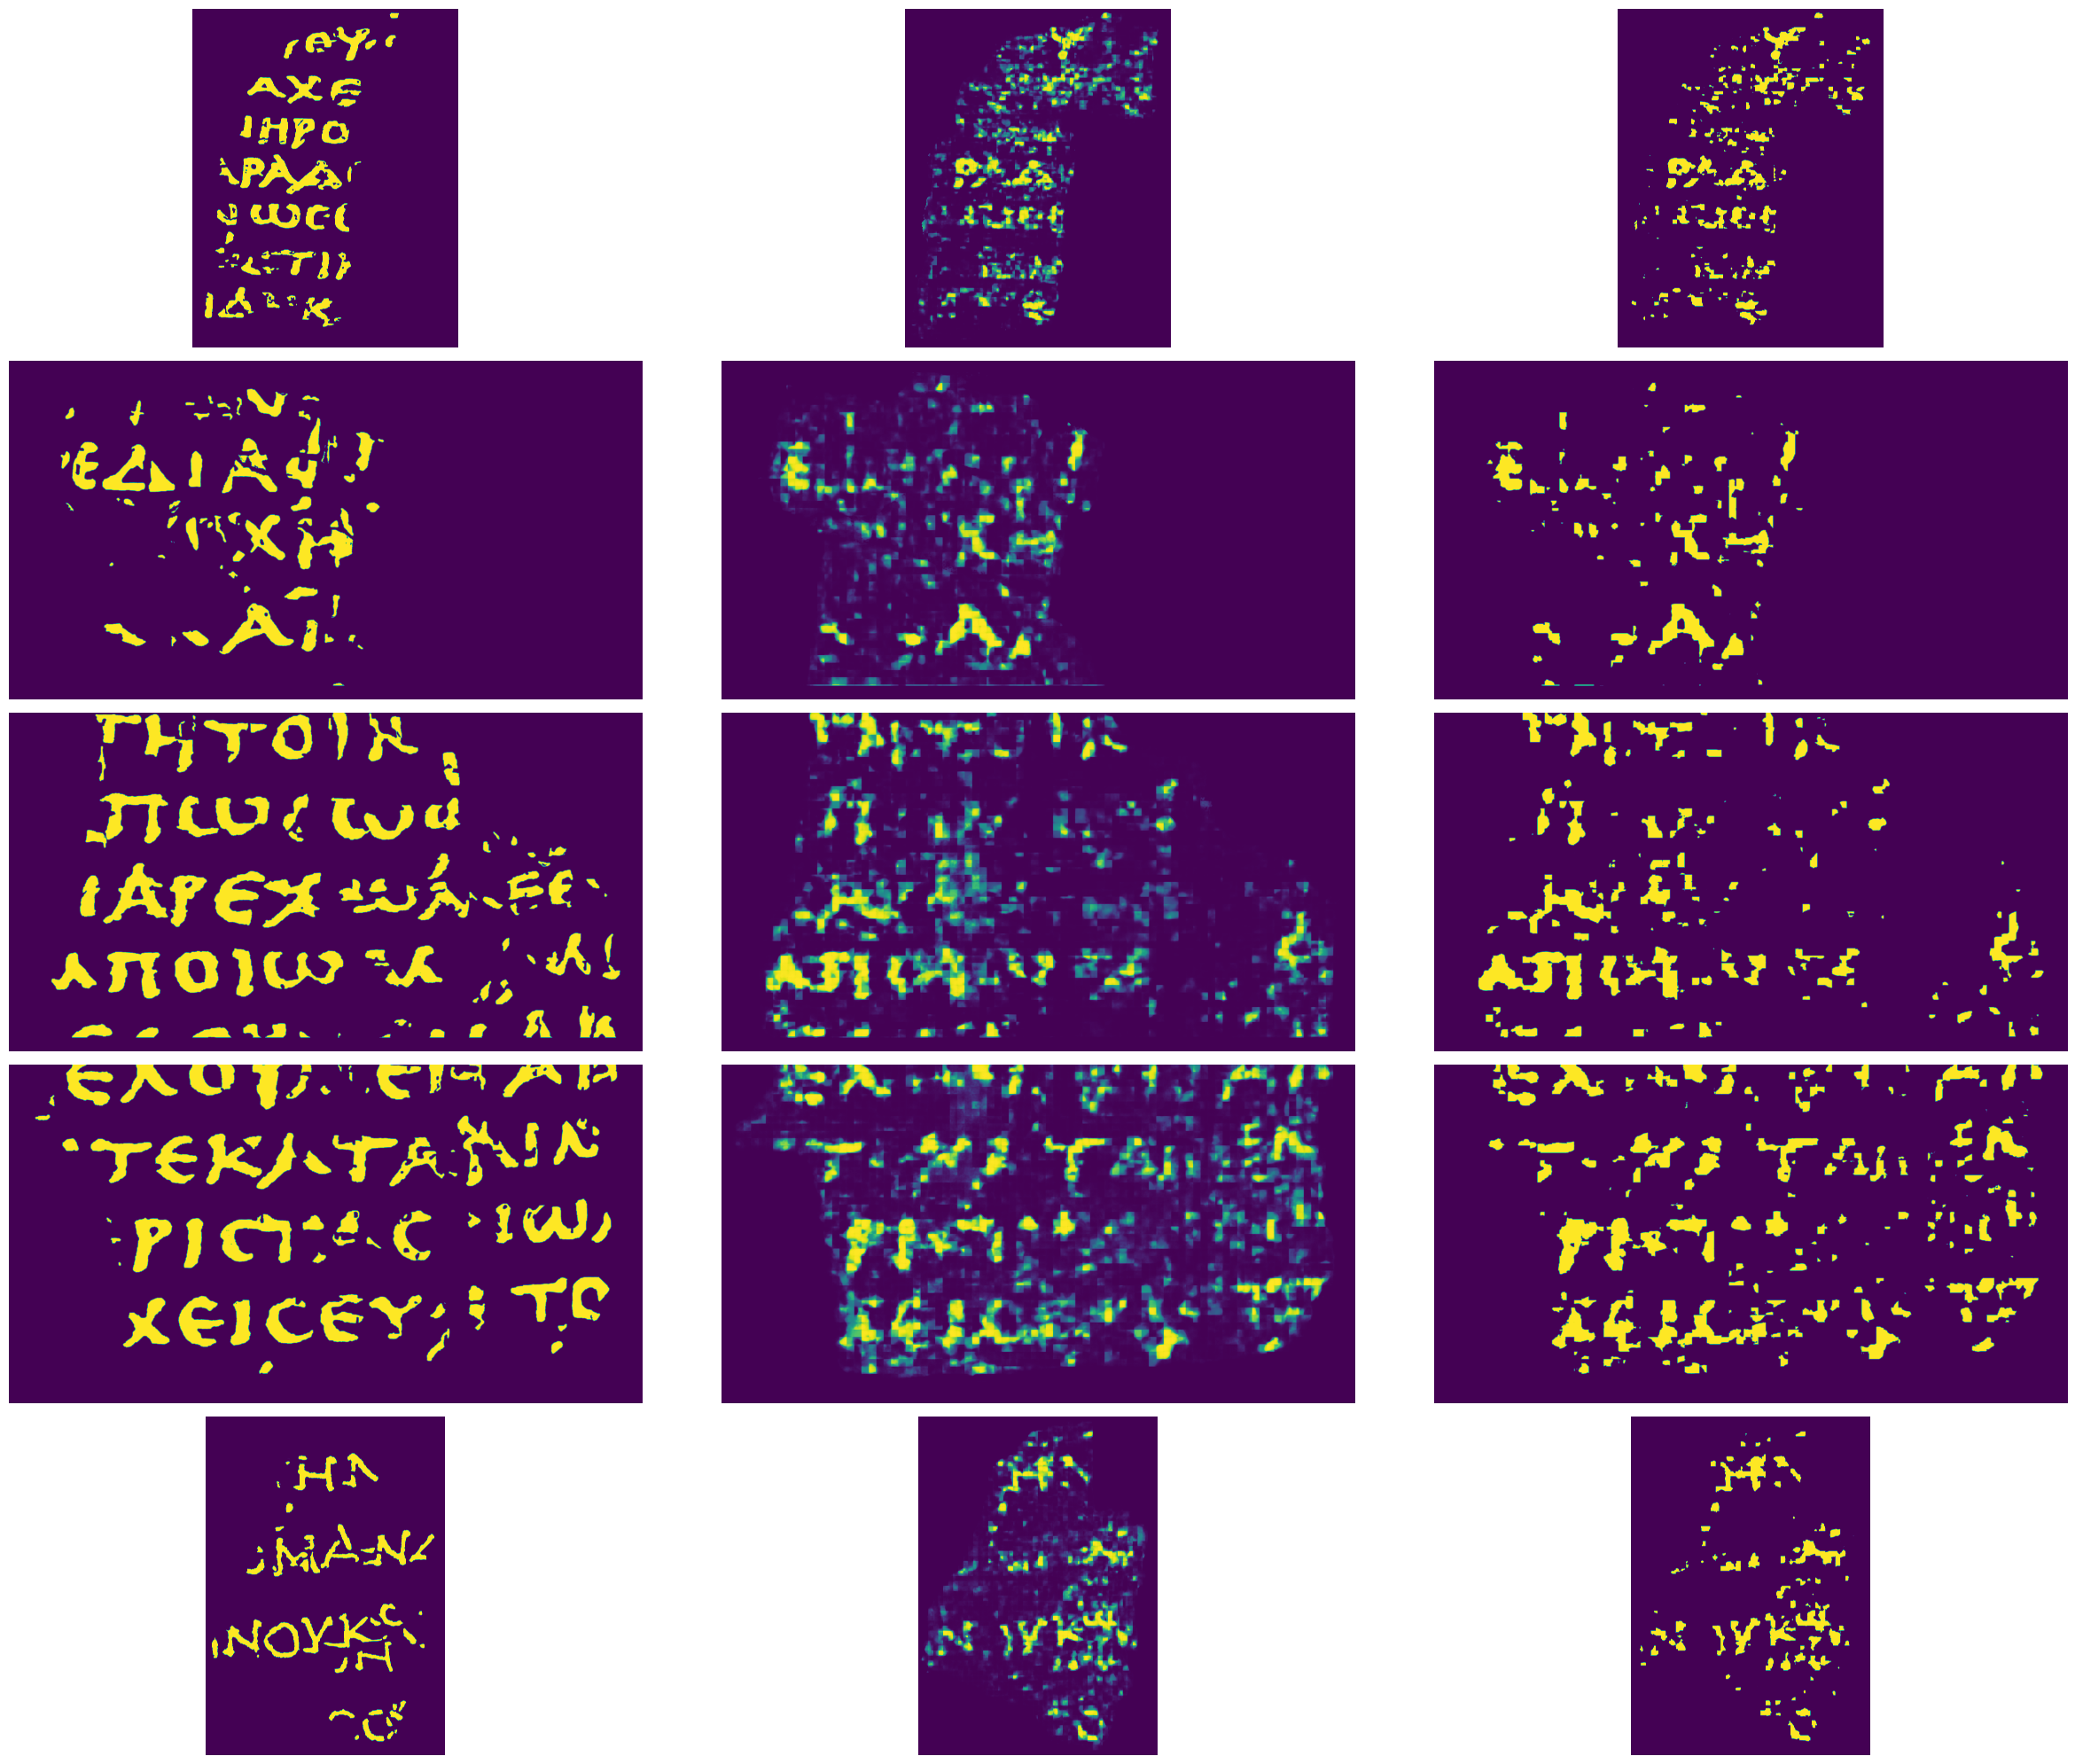

: 

In [14]:
plot_inference(valid_label_gt_list, label_pred_list, CFG)